In [242]:
import pandas as pd
import string
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast

# Data Cleaning

## Merging

In [77]:
import os

In [78]:
files = []
root = "data/"

for item in os.listdir(root):
    if os.path.isfile(os.path.join(root, item)):
        files.append(item)
        
files = [a for a in files if "csv" in a]

In [80]:
df = pd.concat([pd.read_csv("data/" + a, engine='python') for a in files])
df['text'] = df['contents']
df['source'] = df['newspaper']
df['country'] = 'singapore'

df = df[["date", "title", "text", "url", "source", "keyword", "country"]]
df.drop_duplicates(inplace=True)

In [81]:
df.isnull().sum(axis = 0)

date       0
title      0
text       0
url        2
source     0
keyword    0
country    0
dtype: int64

In [82]:
df.dropna(subset=['url'], inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by="date", inplace=True)
df.reset_index(inplace=True, drop=True)

In [83]:
df.groupby("source")['title'].count()

source
straitstimes    25425
tnp               500
Name: title, dtype: int64

In [84]:
df.head()

,date,title,text,url,source,keyword,country
0,2020-01-09,50-year-old in Singapore Poly thankful for hel...,She may have 30 years of experience in the eng...,https://www.tnp.sg/news/singapore/50-year-old-...,tnp,corona,singapore
1,2020-01-10,Six women come forward to adopt abandoned Bedo...,A total of six women have come forward to expr...,https://www.tnp.sg/news/singapore/six-women-co...,tnp,corona,singapore
2,2020-01-10,Schoolgirl found dead at foot of multi-storey ...,A 13-year-old girl from Hai Sing Catholic Scho...,https://www.tnp.sg/news/singapore/girl-bicycle...,tnp,corona,singapore
3,2020-01-10,Wuhan flu caused by new coronavirus: More abou...,BEIJING (AP) - Since late last year people in...,https://www.straitstimes.com/asia/east-asia/wu...,straitstimes,corona,singapore
4,2020-01-11,Facts about coronaviruses,BEIJING ??Since late last year dozens of peop...,https://www.straitstimes.com/asia/east-asia/fa...,straitstimes,corona,singapore


In [85]:
df.to_csv('data/singapore_raw.csv', index=False)

## Clean, Tokenize, Stem, Lemmatize

In [54]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords;
from nltk.tokenize import word_tokenize
STOPWORDS = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yenniejun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yenniejun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yenniejun/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [37]:
STOPWORDS.extend(["said", "also", "would", "like"] )

In [50]:
def clean_text(text):
    remove_char = string.punctuation + '…' + '\xa0' + '·' + '\n' + \
        '※' + '‘' + '’' + '\'' + '▲' + '∼' + "△" + "“" + "”" + "▶" + "․" + \
        "▸"
    text = re.sub('http[s]?://\S+', '', text) # Remove http urls
    text = re.sub('\S*@\S*\s?', '', text) # Remove emails
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub(r'[%s]' % re.escape(remove_char), ' ', text) # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text) # Remove words containing numbers
    text = re.sub('\'', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text.lower()

In [39]:
def preprocess(text):
    result = []
    for token in word_tokenize(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token))
    return result

In [86]:
df = pd.read_csv('data/singapore_raw.csv')

In [88]:
df['clean_text'] = df['text'].map(lambda x: clean_text(x))

In [89]:
# Tokenize and remove stopwords (this takes a while)
df['text_proc_token'] = df['clean_text'].map(preprocess)

In [90]:
df['text_proc'] = df['text_proc_token'].apply(lambda a: ' '.join(a))

In [91]:
# Number mentioning "contact tracing"
contact_tracing = df[df.text.str.contains("contact tracing|contact-tracing|contact tracking|contact-tracking")]
contact_tracing_c = df[df.clean_text.str.contains("contact tracing|contact-tracing|contact tracking|contact-tracking")]

len(contact_tracing), len(contact_tracing_c)

(1146, 1213)

In [92]:
df.text_proc = df.text_proc.str.replace("contact tracking", "contact tracing")
df.text_proc = df.text_proc.str.replace("contacttracking", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact tracked", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact track", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact tracer", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact trace", "contact tracing")
df.text_proc = df.text_proc.str.replace("contacttracer", "contact tracing")
df.text_proc = df.text_proc.str.replace("contacttracing", "contact tracing")
df.text_proc = df.text_proc.str.replace("contacttrace", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact-tracing", "contact tracing")
df.text_proc = df.text_proc.str.replace("contact-tracking", "contact tracing")


In [94]:
df = df.drop_duplicates('text_proc')
df.reset_index(drop=True, inplace=True)
len(df)

25522

In [95]:
df.head()

,date,title,text,url,source,keyword,country,clean_text,text_proc_token,text_proc
0,2020-01-09,50-year-old in Singapore Poly thankful for hel...,She may have 30 years of experience in the eng...,https://www.tnp.sg/news/singapore/50-year-old-...,tnp,corona,singapore,she may have years of experience in the engine...,"[year, experience, engineering, industry, stop...",year experience engineering industry stopped z...
1,2020-01-10,Six women come forward to adopt abandoned Bedo...,A total of six women have come forward to expr...,https://www.tnp.sg/news/singapore/six-women-co...,tnp,corona,singapore,a total of six women have come forward to expr...,"[total, woman, come, forward, express, interes...",total woman come forward express interest cari...
2,2020-01-10,Schoolgirl found dead at foot of multi-storey ...,A 13-year-old girl from Hai Sing Catholic Scho...,https://www.tnp.sg/news/singapore/girl-bicycle...,tnp,corona,singapore,a year old girl from hai sing catholic school ...,"[year, girl, sing, catholic, school, found, mo...",year girl sing catholic school found motionles...
3,2020-01-10,Wuhan flu caused by new coronavirus: More abou...,BEIJING (AP) - Since late last year people in...,https://www.straitstimes.com/asia/east-asia/wu...,straitstimes,corona,singapore,beijing ap since late last year people in the ...,"[beijing, since, late, last, year, people, cen...",beijing since late last year people central ch...
4,2020-01-11,Facts about coronaviruses,BEIJING ??Since late last year dozens of peop...,https://www.straitstimes.com/asia/east-asia/fa...,straitstimes,corona,singapore,beijing since late last year dozens of people ...,"[beijing, since, late, last, year, dozen, peop...",beijing since late last year dozen people chin...


In [129]:
df = df[~df.text_proc.isnull()]

In [130]:
df = df[df.date <= "2020-06-24"]

In [131]:
len(df)

15488

In [132]:
contact_tracing = df[df.text_proc.str.contains("contact tracing")]
len(contact_tracing)

846

In [133]:
df.to_csv("data/text_proc.csv", index=False)

## Topic Model


In [134]:
df = pd.read_csv("data/text_proc.csv")

In [66]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;

In [67]:
def show_topics(a, vocab, num_top_words):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [68]:
# https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6
def document_topic_matrix(model, data, n_components):
    # column names
    topicnames = ["Topic" + str(i) for i in range(n_components)]
    # index names
    docnames = ["Doc" + str(i) for i in range(len(data))]
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(model, 2), columns=topicnames, index=docnames)
    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic["dominant_topic"] = dominant_topic
    return df_document_topic

In [69]:
def topic_keyword_matrix(model, vectorizer):
    # Topic-Keyword Matrix
    df_topic_keywords = pd.DataFrame(model.components_)
    # Assign Column and Index
    df_topic_keywords.columns = vectorizer.get_feature_names()
    topicnames = ["Topic" + str(i) for i in range(n_components)]

    df_topic_keywords.index = topicnames
    # View
    df_topic_keywords.head()
    return df_topic_keywords

In [70]:
def topic_keyword_matrix(model, vectorizer):
    # Topic-Keyword Matrix
    df_topic_keywords = pd.DataFrame(model.components_)
    # Assign Column and Index
    df_topic_keywords.columns = vectorizer.get_feature_names()
    topicnames = ["Topic" + str(i) for i in range(n_components)]

    df_topic_keywords.index = topicnames
    # View
    df_topic_keywords.head()
    return df_topic_keywords

In [71]:
def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = vectors[row_id].T.todense()
    return top_tfidf_feats(row, features, top_n)

In [135]:
len(df)

15488

In [136]:
num_articles = len(df)
# num_articles = 10000 # This is for a small subset for playing around

documents = [''.join(a) for a in df[0:num_articles].text_proc] 
sources = df[0:num_articles].source

n_components = 300

In [137]:
nmf = NMF(n_components=n_components, random_state=1, init='nndsvd')
tfidf_vectorizer = TfidfVectorizer(min_df=1, max_df = 0.8, ngram_range = (2,2), lowercase=False, max_features=5000)
tfidf_vectors = tfidf_vectorizer.fit_transform(documents)

In [138]:
# CHECK: Make sure that contact tracing exists in the vectorizer's feature names
"contact tracing" in tfidf_vectorizer.get_feature_names() 

True

In [139]:
%time nmf_tfidf_vec = nmf.fit_transform(tfidf_vectors)

/usr/local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


CPU times: user 13min 11s, sys: 46.4 s, total: 13min 58s
Wall time: 10min 7s


In [141]:
vocab = np.array(tfidf_vectorizer.get_feature_names())
num_top_words = 50
nmf_topics = show_topics(nmf.components_, vocab, num_top_words)

In [142]:
nmf_topics

['subscribe continue please subscribe full article reading full continue reading article please article term condition apply term condition time spoke singapore year department store singapore pool global pandemic alert level standard chartered stock market hubei province grace assembly university student early day human contact financial market singapore covid travel plan infected coronavirus school holiday across world outbreak covid coronavirus epidemic home week time business almost cent covid cluster first confirmed sunday time spreading coronavirus economic growth covid last economic fallout senior consultant airport terminal march year financial year till june measure contain diagnosed covid isolation ward cent compared court heard',
 'united state state china state britain across united europe united state said state department according reuters including united people united state europe china united reuters tally said united latin america state country world largest state pre

In [145]:
# # TO SAVE
with open('models/nmf_vectorizer_bigrams.pk', 'wb') as fin:
    pickle.dump(tfidf_vectorizer, fin)
with open('models/nmf_vectors_bigrams.pk', 'wb') as fin:
    pickle.dump(tfidf_vectors, fin)
with open('models/nmf_tfidf_vec_bigrams.pk', 'wb') as fin:
    pickle.dump(nmf_tfidf_vec, fin)
with open('models/nmf_topics.txt', "w") as fin: 
    fin.writelines("%s\n" % p for p in nmf_topics)


## Node List

In [152]:
with open('models/nmf_vectors_bigrams.pk', 'rb') as fin:
    vectors = pickle.load(fin)
with open('models/nmf_tfidf_vec_bigrams.pk', 'rb') as fin:
    vec = pickle.load(fin)
topics = pd.read_csv('models/nmf_topics.txt', header=None)

In [153]:
num_articles = len(df)
# num_articles = 10000 # This is for a small subset for playing around

documents = [''.join(a) for a in df[0:num_articles].text_proc] 
sources = df[0:num_articles].source

n_components = 300

In [154]:
# Build the document-topic matrix
# https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6

topicnames = ["Topic" + str(i) for i in range(n_components)]
docnames = ["Doc" + str(i) for i in range(len(documents))] # Index names
doc_top_matrix = pd.DataFrame(np.round(vec, 3), columns=topicnames, index=docnames)
mean = doc_top_matrix.apply(lambda row: np.mean(row.values[np.nonzero(row.values)]),axis=1)
median = doc_top_matrix.apply(lambda row: np.median(row.values[np.nonzero(row.values)]),axis=1)
doc_top_matrix.loc[:, "mean"] = mean
doc_top_matrix.loc[:, "median"] = median

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plot the distribution of one document

0.010130434782608697


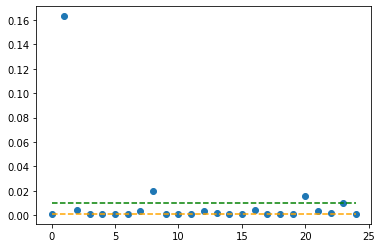

In [157]:
doc  = doc_top_matrix.loc['Doc0'].values
fig,ax = plt.subplots()

vals = np.nonzero(doc)
x = range(0,len(doc[vals]))

mean = doc[-2]
median = doc[-1]
print(mean)
means = [mean]*len(doc[vals])
medians = [median]*len(doc[vals])

ax.scatter(range(0,len(doc[vals])), doc[vals])
ax.plot(x, means, linestyle='--', color="green")
ax.plot(x, medians, linestyle="--", color="orange")

plt.show()

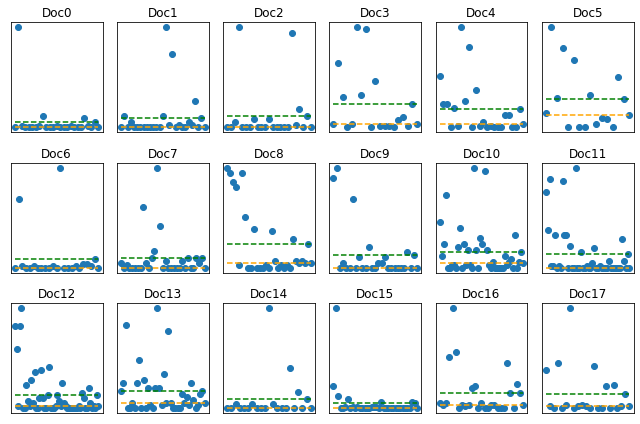

In [158]:
grid = np.random.rand(4, 4)
docs = [f"Doc{a}" for a in range(18)]

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, docname in zip(axs.flat, docs):
    doc  = doc_top_matrix.loc[docname].values
    vals = np.nonzero(doc)
    x = range(0,len(doc[vals]))

    mean = [doc[-2]]*len(doc[vals])
    median = [doc[-1]]*len(doc[vals])

    ax.scatter(range(0,len(doc[vals])), doc[vals])
    ax.plot(x, mean, linestyle='--', color="green")
    ax.plot(x, median, linestyle="--", color="orange")
    ax.set_title(docname)

plt.tight_layout()
plt.show()

In [160]:
doc_top_matrix.to_csv("proc/doc_top_matrix.csv")

In [161]:
def discretize(row):
    if pd.notnull(row['mean']):
        row[row < row['mean']] = 0
        row[row >= row['mean']] = 1
        return row.astype(int)
    else: 
        return row
        

In [178]:
discrete_dtm = doc_top_matrix.copy().apply(lambda row: discretize(row), axis=1)

In [179]:
discrete_dtm = discrete_dtm.fillna(0)
discrete_dtm = discrete_dtm.astype(int)

In [180]:
discrete_dtm.drop(columns=["mean", "median"], inplace=True)

In [181]:
sums = discrete_dtm.sum(axis=0)
discrete_dtm['source'] = sources.values

In [182]:
discrete_dtm.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic291,Topic292,Topic293,Topic294,Topic295,Topic296,Topic297,Topic298,Topic299,source
Doc0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,tnp
Doc1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,tnp
Doc2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,tnp
Doc3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,straitstimes
Doc4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,straitstimes


In [183]:
discrete_dtm.to_csv("proc/discrete_dtm.csv")

In [184]:
discrete_dtm = pd.read_csv("proc/discrete_dtm.csv")

In [185]:
node_list = discrete_dtm.groupby('source').sum().T

In [186]:
node_list

source,straitstimes,tnp
Topic0,279,0
Topic1,1878,7
Topic2,598,7
Topic3,625,57
Topic4,666,8
...,...,...
Topic295,418,20
Topic296,273,7
Topic297,383,12
Topic298,521,7


In [187]:
len(sums)

300

In [188]:
node_list.columns

Index(['straitstimes', 'tnp'], dtype='object', name='source')

In [189]:
node_list["totalcount"] = sums.values
node_list["label"] = topics.values

# Change the order
node_list = node_list[["label", "totalcount", 'straitstimes', 'tnp']]

In [190]:
node_list.label = node_list.label.apply(lambda row: [re.search("\w+", a).group(0) for a in row.split()])

In [191]:
node_list.sort_values(by="totalcount", ascending=False).head(30)

source,label,totalcount,straitstimes,tnp
Topic12,"[white, house, trump, administration, administ...",2622,2578,44
Topic1,"[united, state, state, china, state, britain, ...",1885,1878,7
Topic22,"[social, distancing, distancing, rule, distanc...",1662,1634,28
Topic24,"[strait, time, told, strait, time, understands...",1597,1572,25
Topic42,"[covid, pandemic, amid, covid, pandemic, said,...",1539,1517,22
Topic29,"[last, year, period, last, late, last, compare...",1534,1508,26
Topic44,"[coronavirus, pandemic, amid, coronavirus, glo...",1511,1499,12
Topic61,"[coronavirus, outbreak, amid, coronavirus, sin...",1427,1385,42
Topic55,"[last, week, said, last, week, said, unemploym...",1353,1317,36
Topic35,"[chief, executive, executive, officer, group, ...",1186,1162,24


In [192]:
node_list.reset_index(inplace=True)
node_list.rename(columns={"index": "topic", "source": "index"}, inplace=True)

node_list.to_csv("proc/nodelist.csv")

In [193]:
node_list

source,topic,label,totalcount,straitstimes,tnp
0,Topic0,"[subscribe, continue, please, subscribe, full,...",279,279,0
1,Topic1,"[united, state, state, china, state, britain, ...",1885,1878,7
2,Topic2,"[circuit, breaker, breaker, measure, measure, ...",605,598,7
3,Topic3,"[case, year, year, singaporean, travel, histor...",682,625,57
4,Topic4,"[hong, kong, national, security, four, people,...",674,666,8
...,...,...,...,...,...
295,Topic295,"[italian, football, football, federation, semi...",438,418,20
296,Topic296,"[youtube, channel, music, video, living, room,...",280,273,7
297,Topic297,"[school, public, hock, school, swee, hock, ass...",395,383,12
298,Topic298,"[narendra, modi, minister, narendra, nationwid...",528,521,7


In [197]:
# Contact tracing ones! 
node_list.reindex([28])

source,topic,label,totalcount,straitstimes,tnp
28,Topic28,"[contact, tracing, personal, data, smart, nati...",610,583,27


## Edge List

In [198]:
from itertools import combinations
from collections import OrderedDict 
from dateutil.parser import parse


In [200]:
df = pd.read_csv("data/text_proc.csv")
doc_top_matrix = pd.read_csv("proc/doc_top_matrix.csv")
discrete_dtm = pd.read_csv("proc/discrete_dtm.csv")

In [201]:
def get_weekday(num):
    # https://docs.python.org/3/library/datetime.html#datetime.date.isocalendar
    if num == 1: return "Monday"
    if num == 2: return "Tuesday"
    if num == 3: return "Wednesday"
    if num == 4: return "Thursday"
    if num == 5: return "Friday"
    if num == 6: return "Saturday"
    if num == 7: return "Sunday"

In [202]:
# def get_political(source):
#     """
#     Returns true if liberal, false if conservative
#     """
#     if source in ["한겨레", "경향신문"]:
#         return "liberal"
#     else: return "conservative"

In [203]:
def choose(n, k):
    # https://stackoverflow.com/questions/3025162/statistics-combinations-in-python/3025194#3025194
    """
    A fast way to calculate binomial coefficients by Andrew Dalke (contrib).
    """
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0

In [204]:
new_columns = discrete_dtm.columns.values
discrete_dtm.columns = new_columns

In [205]:
# Number of topics in each document
num_topics_per_document_list = discrete_dtm.sum(axis=1).values

# Figure out combinations space
num_combinations = sum([choose(a, 2) for a in num_topics_per_document_list[:-1]])


In [206]:
num_combinations

279598

In [208]:
# Then pre-allocate that much space for the df that will hold the edge list
columns = ["node1", "node2", "documentId", "date", "day_of_week", "week_of_year", "month", "newssource"]
edgelist = pd.DataFrame(columns=columns, index=range(num_combinations))


In [210]:
discrete_dtm.loc[:,'num_topics_in_document'] = num_topics_per_document_list

In [211]:
df.reset_index(inplace=True, drop=True)

In [ ]:
i = 0
for index, row in discrete_dtm.iterrows():
    print(index)
    if row.num_topics_in_document > 1:
#         print(row.num_topics_in_document)
        
        documentId = index#int(re.search('\d+', index).group())
        document = df.loc[documentId] # fetch document
        newssource = document.source
        # political = get_political(newssource)
        
        date = parse(document.date)
#         print(document.source)
        _, week_of_year, day_of_week = date.isocalendar()
        month = date.month
        day_of_week = get_weekday(day_of_week)
        
        topic_combinations = combinations(row.index[row == 1], 2)
        
        for node1, node2 in topic_combinations:
#             print(node1, node2)
            
            onerow = pd.Series({"node1": node1, "node2": node2, "documentId": documentId, 
                                "date": date, "day_of_week": day_of_week, "week_of_year": week_of_year,
                                "month": month, "newssource": newssource})
            
            edgelist.iloc[i] = onerow
            i += 1


In [213]:
edgelist

,node1,node2,documentId,date,day_of_week,week_of_year,month,newssource
0,Topic26,Topic116,0,2020-01-09 00:00:00,Thursday,2,1,tnp
1,Topic26,Topic279,0,2020-01-09 00:00:00,Thursday,2,1,tnp
2,Topic116,Topic279,0,2020-01-09 00:00:00,Thursday,2,1,tnp
3,Topic26,Topic260,1,2020-01-10 00:00:00,Friday,2,1,tnp
4,Topic26,Topic271,1,2020-01-10 00:00:00,Friday,2,1,tnp
...,...,...,...,...,...,...,...,...
279593,Topic29,Topic42,15486,2020-06-24 00:00:00,Wednesday,26,6,straitstimes
279594,Topic29,Topic128,15486,2020-06-24 00:00:00,Wednesday,26,6,straitstimes
279595,Topic39,Topic42,15486,2020-06-24 00:00:00,Wednesday,26,6,straitstimes
279596,Topic39,Topic128,15486,2020-06-24 00:00:00,Wednesday,26,6,straitstimes


In [214]:
edgelist.to_csv("proc/edgelist.csv")

In [221]:
# WEIGHTED EDGE LIST

df_weight = edgelist[["node1", "node2"]]
df_weight = df_weight.groupby(df_weight.columns.tolist(),as_index=False).size().reset_index().rename(columns={'size':'weight'})


In [222]:
df_weight

,index,node1,node2,weight
0,0,Topic0,Topic1,17
1,1,Topic0,Topic10,1
2,2,Topic0,Topic101,4
3,3,Topic0,Topic105,1
4,4,Topic0,Topic108,1
...,...,...,...,...
24660,24660,Topic99,Topic282,1
24661,24661,Topic99,Topic289,1
24662,24662,Topic99,Topic290,1
24663,24663,Topic99,Topic291,2


In [223]:
df_weight[df_weight['weight'] > 1]

,index,node1,node2,weight
0,0,Topic0,Topic1,17
2,2,Topic0,Topic101,4
5,5,Topic0,Topic111,2
7,7,Topic0,Topic114,3
8,8,Topic0,Topic115,2
...,...,...,...,...
24653,24653,Topic99,Topic159,2
24656,24656,Topic99,Topic193,3
24658,24658,Topic99,Topic259,2
24663,24663,Topic99,Topic291,2


In [224]:
df_weight.sort_values("weight", ascending=False, inplace=True)
weights = df_weight.sort_values("weight", ascending=False).weight.values


(array([11., 16., 12.,  7.,  4.,  9.,  4.,  5.,  1.,  4.,  4.,  4.,  2.,
         0.,  5.,  2.,  2.,  1.,  0.,  4.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.]),
 array([125. , 132.2, 139.4, 146.6, 153.8, 161. , 168.2, 175.4, 182.6,
        189.8, 197. , 204.2, 211.4, 218.6, 225.8, 233. , 240.2, 247.4,
        254.6, 261.8, 269. , 276.2, 283.4, 290.6, 297.8, 305. , 312.2,
        319.4, 326.6, 333.8, 341. ]),
 <BarContainer object of 30 artists>)

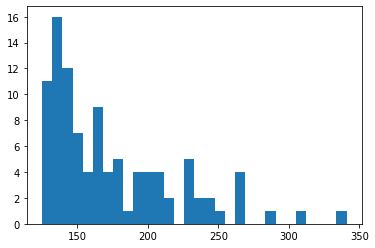

In [225]:
plt.hist(weights[:100], bins = 30)

In [226]:
df_weight

,index,node1,node2,weight
314,314,Topic1,Topic7,341
263,263,Topic1,Topic29,310
195,195,Topic1,Topic22,290
13297,13297,Topic29,Topic42,268
305,305,Topic1,Topic61,264
...,...,...,...,...
4471,4471,Topic133,Topic195,1
4472,4472,Topic133,Topic197,1
4473,4473,Topic133,Topic208,1
16825,16825,Topic49,Topic65,1


In [227]:
df_weight.to_csv("proc/edgelist_weight.csv")

## Filtering, finding articles to analyze

In [239]:
def list_flatten(l, a=None):
    #check a
    if a is None:
        #initialize with empty list
        a = []

    for i in l:
        if isinstance(i, list):
            list_flatten(i, a)
        else:
            if (len(i) != 1): a.append(i)
    return a

In [240]:
df = pd.read_csv("data/text_proc.csv")
edgelist_full = pd.read_csv("proc/edgelist.csv")

edgelist = pd.read_csv("proc/edgelist_weight.csv")
edgelist.drop(columns="Unnamed: 0", inplace=True)

nodelist = pd.read_csv("proc/nodelist.csv")
nodelist.drop(columns="Unnamed: 0", inplace=True)

In [230]:
topics = pd.read_csv('models/nmf_topics.txt', header=None)

In [231]:
topics

,0
0,subscribe continue please subscribe full artic...
1,united state state china state britain across ...
2,circuit breaker breaker measure measure kicked...
3,case year year singaporean travel history rece...
4,hong kong national security four people china ...
...,...
295,italian football football federation semi fina...
296,youtube channel music video living room online...
297,school public hock school swee hock associate ...
298,narendra modi minister narendra nationwide loc...


In [232]:
topics.reindex([28])

,0
28,contact tracing personal data smart nation che...


In [233]:
# Contact tracing indexes
ct_idxs = ["Topic28"]

ct_topics = edgelist[edgelist['node1'].isin(ct_idxs)]
ct_topics = ct_topics.append(edgelist[edgelist['node2'].isin(ct_idxs)])
ct_topics = ct_topics.sort_values(by="weight", ascending=False)

In [234]:
ct_topics

,index,node1,node2,weight
90,10348,Topic22,Topic28,130
103,12949,Topic28,Topic58,121
171,1762,Topic11,Topic28,103
177,13549,Topic3,Topic28,102
180,12954,Topic28,Topic63,102
...,...,...,...,...
21073,12841,Topic28,Topic168,1
21070,12861,Topic28,Topic223,1
21068,12795,Topic28,Topic118,1
21053,12786,Topic28,Topic109,1


In [235]:
edges = ct_topics[:15]

In [245]:
topics = list(set(list_flatten(edges[['node1', 'node2']].values.tolist())))

# dictionary mapping topic to name
topic_name_dict = nodelist[nodelist.topic.isin(topics)]
topic_name_dict.loc[:,"label"] = topic_name_dict.label.apply(lambda a: ast.literal_eval(a))

In [247]:
nodelist_weighted = nodelist.sort_values(by="totalcount", ascending=False)
nodelist_weighted.reset_index(drop=False, inplace=True)
nodelist_weighted[nodelist_weighted.topic.isin(ct_idxs)]

,index,topic,label,totalcount,straitstimes,tnp
29,28,Topic28,"['contact', 'tracing', 'personal', 'data', 'sm...",610,583,27


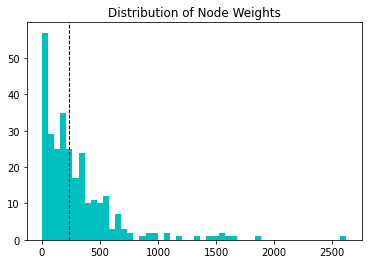

In [248]:
weights = nodelist_weighted[nodelist_weighted.totalcount != 0]
weights = weights[weights.totalcount < 3000].totalcount.values

result = plt.hist(weights, 50, color='c')
result = plt.axvline(230, color='k', linestyle='dashed', linewidth=1) # 91 - 接觸者 追蹤
result = plt.title("Distribution of Node Weights")

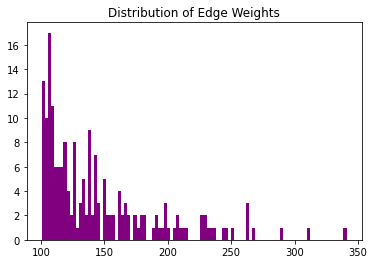

In [250]:
e_weights = edgelist[edgelist.weight > 100]
e_weights = e_weights.weight.values

result = plt.hist(e_weights, 100, color = 'purple')
result = plt.title("Distribution of Edge Weights")

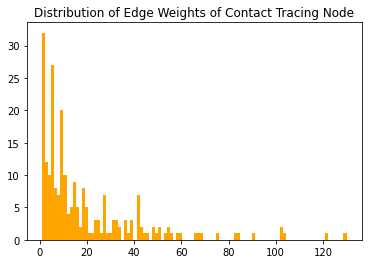

In [251]:
result = plt.hist(ct_topics.weight.values, 100, color = 'orange')
result = plt.title("Distribution of Edge Weights of Contact Tracing Node")

In [252]:
len(ct_topics)

231

In [257]:
print(
    len(ct_topics[ct_topics.weight > 30]),
    len(ct_topics[ct_topics.weight > 15]), 
    len(ct_topics[ct_topics.weight > 10]) 
)

49 87 115


In [283]:
threshold = 30
# threshold = 15
# threshold = 10

top_edges = ct_topics[ct_topics.weight > threshold]

# top_edges

In [ ]:
os.makedirs(f"texts_to_analyze_{threshold}")


In [271]:
for index, row in top_edges.iterrows():
    # Find all the edges that include this specific edge
    edges = edgelist_full[(edgelist_full.node1 == row.node1) & (edgelist_full.node2 == row.node2)]
    
    # Get the document ids
    docIds = edges.documentId.values
    
    # Get the documents corresponding to these edges
    documents = df[df.index.isin(docIds)][["title", "date", "url", "keyword", "text", "source"]]
    documents.reset_index(inplace=True)
    
    textfile = f"[{len(edges)}]{row.node1}-{row.node2}.csv"
    print(textfile)
    
    documents.to_csv(f"texts_to_analyze_{threshold}/{textfile}")

[130]Topic22-Topic28.csv
[121]Topic28-Topic58.csv
[103]Topic11-Topic28.csv
[102]Topic3-Topic28.csv
[102]Topic28-Topic63.csv
[91]Topic23-Topic28.csv
[84]Topic24-Topic28.csv
[83]Topic28-Topic90.csv
[75]Topic1-Topic28.csv
[69]Topic28-Topic55.csv
[68]Topic28-Topic61.csv
[66]Topic28-Topic170.csv
[60]Topic25-Topic28.csv
[59]Topic20-Topic28.csv
[56]Topic28-Topic143.csv
[55]Topic28-Topic283.csv
[54]Topic10-Topic28.csv
[53]Topic28-Topic108.csv
[51]Topic28-Topic294.csv
[51]Topic28-Topic83.csv
[50]Topic28-Topic62.csv
[48]Topic28-Topic106.csv
[48]Topic28-Topic129.csv
[46]Topic28-Topic297.csv
[44]Topic28-Topic248.csv
[43]Topic28-Topic112.csv
[43]Topic2-Topic28.csv
[42]Topic28-Topic29.csv
[42]Topic28-Topic155.csv
[41]Topic18-Topic28.csv
[41]Topic28-Topic104.csv
[41]Topic28-Topic94.csv
[41]Topic28-Topic76.csv
[41]Topic28-Topic42.csv
[39]Topic28-Topic35.csv
[39]Topic28-Topic163.csv
[39]Topic28-Topic150.csv
[38]Topic28-Topic50.csv
[37]Topic28-Topic267.csv
[37]Topic28-Topic263.csv
[36]Topic6-Topic28.csv

In [286]:
# get the list of nodes/topics
topics = list(set(list_flatten(top_edges[['node1', 'node2']].values.tolist())))

# dictionary mapping topic to name
topic_name_dict = nodelist[nodelist.topic.isin(topics)]
topic_name_dict.loc[:,"label"] = topic_name_dict.label.apply(lambda a: ast.literal_eval(a))

In [288]:
node1_bow = []
node2_bow = []

for index, row in top_edges.iterrows():
    bow = topic_name_dict[topic_name_dict.topic == row.node1].label.values[0]
    node1_bow.append(' '.join(["-".join(bow[i:i+2]) for i in range(0, len(bow), 2)]))
    
    bow = topic_name_dict[topic_name_dict.topic == row.node2].label.values[0]
    node2_bow.append(' '.join(["-".join(bow[i:i+2]) for i in range(0, len(bow), 2)]))
    
    
top_edges.loc[:, "node1_bow"] = node1_bow
top_edges.loc[:, "node2_bow"] = node2_bow

In [289]:
top_edges.to_csv(f"texts_to_analyze_{threshold}/top_edges_table.csv")